###  Imports

In this section, we load all the libraries needed for our Naive Bayes implementation:

- **pandas / numpy** — data loading and numerical operations  
- **matplotlib / seaborn** — visualizing data distributions  
- **train_test_split** — splitting data into train/test sets  
- **accuracy_score, classification_report, confusion_matrix** — evaluating model performance  
- **MultinomialNB** — built-in Naive Bayes for comparison  
- **LabelEncoder** — converting categorical values into numeric form  

These tools allow us to preprocess the data, implement Naive Bayes manually, visualize results, and compare with sklearn’s version.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder

###  Loading the Dataset

We load the Adult Income dataset from the UCI Machine Learning Repository and select only the **categorical features** along with the target label:

- Read the data using `pandas.read_csv`
- Assign column names manually (since the raw file has no header)
- Keep only categorical columns plus the target **income**
- Create a new dataframe `df_cat` for our Naive Bayes implementation

This gives us a clean subset of discrete features suitable for manual probability calculations.


In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num', 
    'marital-status', 'occupation', 'relationship', 'race', 'sex', 
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
] #The raw file at that URL does not have a header row 

df = pd.read_csv(url, header=None, names=columns, skipinitialspace=True) #This is the Pandas function that goes to the url, downloads the text, and turns it into a table
#header=None tells Pandas that the first row is not a header row
#names=columns tells Pandas to use our list of column names as the header row
#skipinitialspace=True removes any leading spaces after the commas "Male" instead of " Male"


# Filter for categorical/discrete features as requested
# We keep the target 'income' and the relevant categorical columns
categorical_cols = [
    'workclass', 'education', 'marital-status', 'occupation', 
    'relationship', 'race', 'sex', 'native-country'
]
target_col = 'income'

# Create a subset with only categorical features + target
df_cat = df[categorical_cols + [target_col]].copy()

print(f"Dataset loaded. Shape: {df_cat.shape}")
df_cat.head()

Dataset loaded. Shape: (32561, 9)


,workclass,education,marital-status,occupation,relationship,race,sex,native-country,income
0,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,United-States,<=50K
1,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,United-States,<=50K
2,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,United-States,<=50K
3,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,United-States,<=50K
4,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,Cuba,<=50K


###  Encoding & Splitting the Data — What Each Step Does

- `df_cat = df_cat.replace('?', 'Missing')`  
  Replaces unknown values `"?"` with a clearer label.

- Encode target (`income`) into binary:  
  `>50K → 1`, `<=50K → 0`.

- Encode each categorical feature with `LabelEncoder`:  
  Converts text categories into integers so Naive Bayes can process them.

- Store each encoder in `encoders` to keep mappings if needed later.

- Create `X_encoded_values` and `y_encoded` as NumPy arrays for model training.

- **Train/Val/Test split:**  
  - First: 70% training, 30% temporary  
  - Second: split the 30% into 15% validation and 15% test  
  - `stratify` keeps income classes balanced in all subsets.

- Print the size of each split to confirm correct proportions.


In [ ]:
df_cat = df_cat.replace('?', 'Missing')

# 2. Encode Target Variable (>50K: 1, <=50K: 0)
df_cat['income_encoded'] = df_cat['income'].apply(lambda x: 1 if x == '>50K' else 0)

# 3. Encode Categorical Features as Integers
# We use LabelEncoder but keep track of mappings to maintain interpretability if needed
encoders = {} #Creates an empty dictionary. We will use this to save our "translation keys" (e.g., remembering that 4 = "Private").
X_encoded = pd.DataFrame()

for col in categorical_cols:
    le = LabelEncoder()
    # Fit transform and store the encoder
    X_encoded[col] = le.fit_transform(df_cat[col])
    # Fit: Looks at all unique words in that column (e.g., "Bachelors", "Masters", "PhD") and assigns them IDs (0, 1, 2).
    # Transform: Replaces the actual text in the column with those IDs.
    encoders[col] = le

y_encoded = df_cat['income_encoded'].values 
#.values strips away the Pandas table structure (row numbers, column names) and leaves just the raw matrix of numbers becausse The code for the Naive Bayes math (and Scikit-Learn functions) runs much faster on raw NumPy arrays than on Pandas DataFrames
X_encoded_values = X_encoded.values

# 4. Create 70/15/15 Split
# First split: 70% Train, 30% Temp (Validation + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_encoded_values, y_encoded, test_size=0.30, random_state=42, stratify=y_encoded
)
#stratify=y_encoded ensures that the class distribution in the splits matches that of the original dataset if 25% of the original data is class 1, then 25% of the training, validation, and test sets will also be class 1.

# Second split: Split the 30% Temp into 50/50 (which is 15% / 15% of total)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"Training Set: {X_train.shape[0]} samples (70%)")
print(f"Validation Set: {X_val.shape[0]} samples (15%)")
print(f"Test Set: {X_test.shape[0]} samples (15%)")

Training Set: 22792 samples (70%)
Validation Set: 4884 samples (15%)
Test Set: 4885 samples (15%)


### Class Distribution & Feature Analysis

- **Calculate class distribution:**  
  `value_counts(normalize=True)` shows the percentage of samples in each income class (≤50K vs >50K).  
  This helps check if the dataset is imbalanced.

- **Plot income distribution:**  
  A countplot visualizes how many people fall into each income category.

- **Analyze a feature vs the target:**  
  The countplot of `relationship` shows how each relationship type is associated with income levels.  
  This helps us understand which categories may be more predictive.

These visualizations give insight into the dataset before applying Naive Bayes.



Class Distribution (0: <=50K, 1: >50K):
income_encoded
0    0.75919
1    0.24081
Name: proportion, dtype: float64


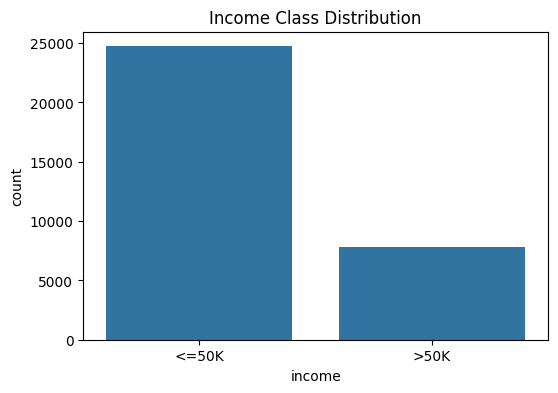

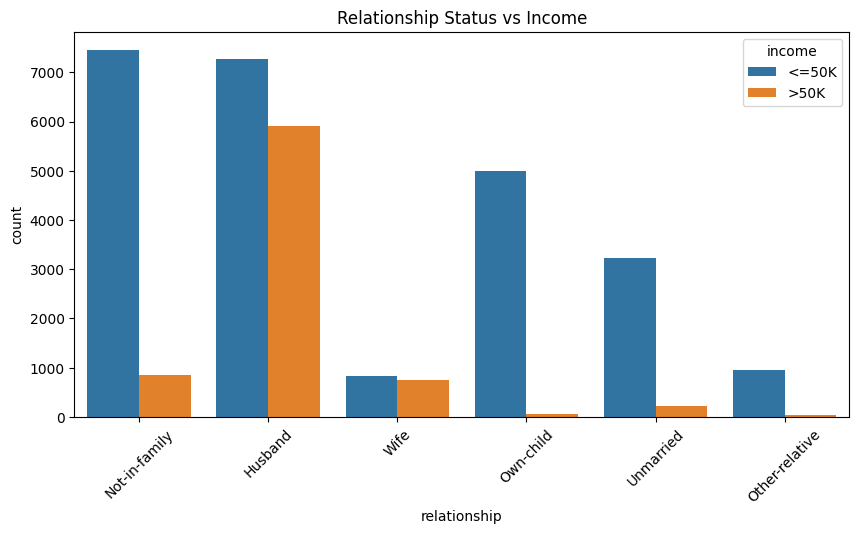

In [4]:
# Analyze Class Distribution
class_counts = df_cat['income_encoded'].value_counts(normalize=True)
print("\nClass Distribution (0: <=50K, 1: >50K):")
print(class_counts)

# Visualize Class Imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x=df_cat['income'])
plt.title("Income Class Distribution")
plt.show()

# Analyze Feature-Target Relationship (e.g., Relationship vs Income)
plt.figure(figsize=(10, 5))
sns.countplot(data=df_cat, x='relationship', hue='income')
plt.title("Relationship Status vs Income")
plt.xticks(rotation=45)
plt.show()

###  Custom Naive Bayes Implementation

This class implements a **manual Naive Bayes classifier** for categorical data, step by step.

#### Key Components:

1. **Initialization (`__init__`)**
   - `alpha`: Laplace smoothing parameter to handle zero probabilities.
   - `class_priors`: Stores prior probabilities \(P(C_k)\) for each class.
   - `feature_likelihoods`: Stores conditional probabilities \(P(x_i \mid C_k)\) for every feature value and class.
   - `feature_counts_per_class`: Counts samples per class for likelihood calculations.

2. **Training (`fit`)**
   - Calculates **class priors**:

     $$
     P(C_k) = \frac{\text{count}(C_k) + \alpha}{\text{total samples} + \alpha \cdot \text{num classes}}
     $$

   - Calculates **feature likelihoods** for every feature value in each class:

     $$
     P(x_i \mid C_k) = \frac{\text{count}(x_i \text{ in } C_k) + \alpha}{\text{count}(C_k) + \alpha \cdot V}
     $$

     where \(V\) is the number of unique values for that feature.

3. **Prediction (`predict_log_proba` & `predict`)**
   - Computes **log probabilities** to prevent numerical underflow:

     $$
     \log P(C_k) + \sum_i \log P(x_i \mid C_k)
     $$

   - Uses `argmax` to select the class with the highest probability for each sample.
   - Handles unseen feature values with a small fallback probability.

#### Why It’s Useful
- Demonstrates **how Naive Bayes works manually**, including priors, likelihoods, and smoothing.
- Can be compared directly with `sklearn`’s `MultinomialNB`.
- Supports categorical features and is easy to extend for other discrete data.


In [ ]:
class CustomNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = {}
        self.feature_likelihoods = {}
        self.classes = None
        self.n_classes = 0
        self.feature_counts_per_class = {} # Stores count of samples in class k
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes = np.unique(y)   #finds the unique class labels in y
        self.n_classes = len(self.classes) #number of unique classes
        
        # 1. Calculate Class Priors
        # Formula: P(C_k) = (count(k) + alpha) / (total_samples + alpha * num_classes)
        for c in self.classes:
            count_k = np.sum(y == c) # c is the class label
            self.feature_counts_per_class[c] = count_k
            
            numerator = count_k + self.alpha
            denominator = n_samples + (self.alpha * self.n_classes)
            self.class_priors[c] = numerator / denominator
            
        # 2. Calculate Feature Likelihoods
        # Formula: P(x_i|C_k) = (count(x_i in C_k) + alpha) / (count(C_k) + alpha * num_feature_values)
        
        # We need to store likelihoods for every feature index, every feature value, for every class
        self.feature_likelihoods = {} 
        
        for feature_idx in range(n_features):
            self.feature_likelihoods[feature_idx] = {}
            
            # Get unique values for this feature to know V (vocab size for this feature)
            unique_values = np.unique(X[:, feature_idx]) #finds all unique values in that feature column x[:, feature_idx ] means "all rows, this specific feature column"
            num_feature_values = len(unique_values) #we use in the denominator for smoothing
            
            for c in self.classes:
                self.feature_likelihoods[feature_idx][c] = {} # Initialize dictionary for this class
                
                # Filter X where class is c
                X_c = X[y == c] #contains only the rows where the class label is c ex: only rows where income is ">50K"
                
                # Count of class C is already stored, but needed for denominator
                count_class_k = self.feature_counts_per_class[c]
                denominator = count_class_k + (self.alpha * num_feature_values) #same denominator for all feature values in this class
                
                for val in unique_values: # Iterate over all possible values of this feature ex: education level 0, 1, 2, ..., 16
                    
                    count_xi_in_k = np.sum(X_c[:, feature_idx] == val)    # Count of feature value val in class c ex: count of "Bachelors" in class ">50K"
                    
                    numerator = count_xi_in_k + self.alpha  
                    prob = numerator / denominator
                    
                    self.feature_likelihoods[feature_idx][c][val] = prob
                    
    def predict_log_proba(self, X):
        # We use log probabilities to prevent underflow
        n_samples, n_features = X.shape
        probs = np.zeros((n_samples, self.n_classes)) # Rows: samples, Columns: classes
        
        for i in range(n_samples): # For each sample
            for idx, c in enumerate(self.classes): #calculate for class >=50K and class <=50K
                # Start with Prior
                log_prob = np.log(self.class_priors[c])
                
                # Add Likelihoods for each feature
                for feature_idx in range(n_features):
                    val = X[i, feature_idx]  #val is the feature value for this sample and feature index ex: education level = 12
                    
                    # Handle unseen values in test set by assigning minimal probability or ignoring
                    # If val is in our dictionary, add its log prob.
                    if val in self.feature_likelihoods[feature_idx][c]:
                        log_prob += np.log(self.feature_likelihoods[feature_idx][c][val])
                    else:
                        # Fallback for unseen value (smoothing usually handles this if V is known globally,
                        # but here we use a simple penalty if strictly unseen during fit)
                        log_prob += np.log(1e-10)  #train data did not have this feature value for this class but it appears in test data ex: education level = 20 
                
                probs[i, idx] = log_prob
        return probs #it returns a 2D array where each row corresponds to a sample and each column corresponds to a class [n_samples x n_classes]=[n_samples x 2]

    def predict(self, X): #x is the feature matrix for which we want to predict class labels
        log_probs = self.predict_log_proba(X)
        # Argmax to get the class index, then map back to class label
        indices = np.argmax(log_probs, axis=1) #This is crucial. It tells Python to check Row by Row (horizontally). If we didn't say axis=1, it might find the max of the entire table.
        return self.classes[indices] #map back to class labels (0 or 1)

print("Custom Naïve Bayes Class defined.")

Custom Naïve Bayes Class defined.


###  Tuning the Smoothing Parameter (Alpha)

- **Alpha (`α`)** controls Laplace smoothing, preventing zero probabilities for unseen feature values.
- We try multiple values: `[0.1, 0.5, 1.0, 2.0, 5.0]`.
- For each alpha:
  1. Train `CustomNaiveBayes` on the training set.
  2. Predict on the validation set.
  3. Compute **accuracy** and store results.
  4. Track the alpha that gives the **highest validation accuracy**.

- Print results in a table for easy comparison.
- After the loop, `best_alpha` holds the optimal smoothing parameter and `best_model` is the corresponding trained model.


In [ ]:
alpha_values = [0.1, 0.5, 1.0, 2.0, 5.0]
results = []

print(f"{'Alpha':<10} | {'Val Accuracy':<15}") #:<10 means left-align within 10 spaces
print("-" * 30) #print a line of 30 dashes

best_alpha = None
best_acc = 0
best_model = None

for alpha in alpha_values:
    nb = CustomNaiveBayes(alpha=alpha)
    nb.fit(X_train, y_train)
    
    y_pred_val = nb.predict(X_val)
    acc = accuracy_score(y_val, y_pred_val)
    
    results.append((alpha, acc))
    print(f"{alpha:<10} | {acc:.4f}")
    
    if acc > best_acc:
        best_acc = acc
        best_alpha = alpha
        best_model = nb

print("-" * 30)
print(f"Best Alpha: {best_alpha} with Validation Accuracy: {best_acc:.4f}")

Alpha      | Val Accuracy   
------------------------------
0.1        | 0.7963
0.5        | 0.7965
1.0        | 0.7963
2.0        | 0.7965
5.0        | 0.7944
------------------------------
Best Alpha: 0.5 with Validation Accuracy: 0.7965


###  Evaluating the Best Model on the Test Set

- Use the **best model** (with optimal alpha) to predict the test set labels.
- Compute **accuracy** to see how well the model generalizes.
- Generate a **classification report** showing precision, recall, and F1-score for both classes (`<=50K` and `>50K`).
- Analyze **predicted log probabilities** for a few test samples:
  - Shows the model's confidence in each class.
  - Each row corresponds to a sample; the two columns show log probabilities for class 0 and class 1.


In [ ]:
# Run best model on Test Set
y_pred_test = best_model.predict(X_test) #best_model is the CustomNaiveBayes instance with the best alpha found during validation
test_acc = accuracy_score(y_test, y_pred_test)

print(f"\nTest Set Accuracy (Custom NB): {test_acc:.4f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_test, target_names=['<=50K', '>50K']))

# Probability Analysis
# Let's look at the distribution of predicted log probabilities for a few samples
log_probs = best_model.predict_log_proba(X_test[:5]) # x_test[:5] means "the first 5 rows of the test feature matrix"
print("Log Probabilities for first 5 test samples (Class 0 vs Class 1):")
print(log_probs)


Test Set Accuracy (Custom NB): 0.7957

Classification Report:

              precision    recall  f1-score   support

       <=50K       0.91      0.81      0.86      3709
        >50K       0.56      0.74      0.64      1176

    accuracy                           0.80      4885
   macro avg       0.73      0.78      0.75      4885
weighted avg       0.82      0.80      0.80      4885

Log Probabilities for first 5 test samples (Class 0 vs Class 1):
[[ -9.04175884 -16.50346635]
 [-19.06567336 -22.99325401]
 [ -9.19344129 -15.09571054]
 [ -9.69127791 -10.4809204 ]
 [-12.37384148 -21.48243961]]


###  Feature Importance / Independence Analysis

- Naive Bayes assumes **features are independent**, but we can still analyze which features are informative.
- A feature is more informative if its **likelihoods differ significantly** between classes.
  
Example: **`relationship` feature**
- Look at the likelihoods \(P(\text{relationship} = \text{value} \mid \text{income class})\) for each possible value.
- Values with large differences between `<=50K` and `>50K` are more predictive of income.
- This helps us understand which features contribute most to classification.


In [ ]:
# FEATURE IMPORTANCE / INDEPENDENCE DISCUSSION
# To analyze feature impact, we can look at the variance in likelihoods
# A feature where P(x|C0) is very different from P(x|C1) is informative.

print("\n--- Feature Analysis ---")
# Let's verify if 'Relationship' (index 4 in our list usually, but let's check index)
# categorical_cols = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
rel_idx = categorical_cols.index('relationship')

print(f"Analyzing Feature: Relationship (Index {rel_idx})")
print("Likelihoods P(Feature=Val | Class):")
vocab = encoders['relationship'].classes_
for val_idx, val_name in enumerate(vocab):
    if val_idx in best_model.feature_likelihoods[rel_idx][0]:
        p_c0 = best_model.feature_likelihoods[rel_idx][0][val_idx]
        p_c1 = best_model.feature_likelihoods[rel_idx][1][val_idx]
        print(f"  Value: {val_name:<15} | P(x|<=50K): {p_c0:.4f} | P(x|>50K): {p_c1:.4f}")



--- Feature Analysis ---
Analyzing Feature: Relationship (Index 4)
Likelihoods P(Feature=Val | Class):
  Value: Husband         | P(x|<=50K): 0.2934 | P(x|>50K): 0.7528
  Value: Not-in-family   | P(x|<=50K): 0.3025 | P(x|>50K): 0.1126
  Value: Other-relative  | P(x|<=50K): 0.0397 | P(x|>50K): 0.0045
  Value: Own-child       | P(x|<=50K): 0.2023 | P(x|>50K): 0.0083
  Value: Unmarried       | P(x|<=50K): 0.1293 | P(x|>50K): 0.0289
  Value: Wife            | P(x|<=50K): 0.0327 | P(x|>50K): 0.0930


### Comparing with Sklearn's MultinomialNB & Independence Discussion

- We fit **Sklearn's `MultinomialNB`** on the same training data using the best alpha.  
  - Note: `MultinomialNB` expects integer counts/frequencies, so using categorical indices is a simplification.  
  - For purely categorical data, `CategoricalNB` would be more appropriate, but the comparison is requested with `MultinomialNB`.

- **Accuracy comparison:**  
  - `Custom Naive Bayes`: test accuracy from our manual implementation.  
  - `Sklearn MultinomialNB`: test accuracy using sklearn’s built-in model.

- **Feature independence assumption:**  
  - Naive Bayes assumes all features are independent given the class.  
  - In reality, some features are correlated (e.g., `Education` & `Occupation`, `Sex` & `Relationship`).  
  - Violating this assumption can make the model **overconfident** in probabilities, but classification accuracy often remains good.


In [9]:
# Sklearn's MultinomialNB works with integer counts/frequencies. 
# Since we have categorical indices, strict MultinomialNB might assume these are counts.
# However, for categorical Naive Bayes, CategoricalNB is technically more correct, 
# but the prompt asks to compare with MultinomialNB specifically.

# Sklearn MultinomialNB Fit
sk_nb = MultinomialNB(alpha=best_alpha)
sk_nb.fit(X_train, y_train)
sk_y_pred = sk_nb.predict(X_test)
sk_acc = accuracy_score(y_test, sk_y_pred)

print(f"Custom NB Accuracy:  {test_acc:.4f}")
print(f"Sklearn NB Accuracy: {sk_acc:.4f}")

# Discussion on Independence
print("\n--- Independence Assumption Discussion ---")
print("Naive Bayes assumes that all features are independent given the class.")
print("In this dataset, this is likely violated. For example:")
print("1. 'Education' and 'Occupation' are highly correlated.")
print("2. 'Sex' and 'Relationship' (e.g., Husband/Wife) are correlated.")
print("Violating this assumption leads to 'double counting' evidence, making the model")
print("overconfident in its probabilities, though often still accurate in classification.")

Custom NB Accuracy:  0.7957
Sklearn NB Accuracy: 0.7484

--- Independence Assumption Discussion ---
Naive Bayes assumes that all features are independent given the class.
In this dataset, this is likely violated. For example:
1. 'Education' and 'Occupation' are highly correlated.
2. 'Sex' and 'Relationship' (e.g., Husband/Wife) are correlated.
Violating this assumption leads to 'double counting' evidence, making the model
overconfident in its probabilities, though often still accurate in classification.
